# Churchland Widefield Data

This notebook demonstrates:
- Plot PCA latents and PCA latent trajectory for left vs right
- Plot PCA latents and PCA latent trajectory for reward vs non-reward
This is done in the representative mSM30 mouse, for the 10-Oct-2017 session

In [1]:
import numpy as np
import pandas as pd
import ssm
import seaborn as sns
import numpy.random as npr
import matplotlib.pyplot as plt
import numpy.linalg as la
from collections import OrderedDict
from matplotlib.font_manager import FontProperties
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from sklearn.decomposition import PCA
from ssm import LDS
from Session import *
from LVM import *

sns.set_style("white")
sns.set_context("talk")

## Load Session and run LVM-PCA

In [2]:
session = Session("vistrained", "mSM30", "10-Oct-2017")
delay_period_indices = session.get_delay_period()
quiescent_indices, quiescent_activity = session.get_quiescent_activity()

In [3]:
[k for k in session.trialmarkers]

['CorrectSide',
 'ResponseSide',
 'Rewarded',
 'levGrabL',
 'levGrabR',
 'levReleaseL',
 'levReleaseR',
 'leverIn',
 'lickL',
 'lickR',
 'spoutTime',
 'stimTime',
 'water']

In [3]:
all_neural_data = session.neural['neural']

In [4]:
delay_data = []
min_delay_size = np.min([x[1]-x[0] for x in delay_period_indices])
for trial in range(delay_period_indices.shape[0]):
    start = delay_period_indices[trial,:][0]
    delay_activity = all_neural_data[trial,start:start + min_delay_size,:]
    delay_data.append(delay_activity)
delay_data = np.array(delay_data)

In [5]:
lvm_pca = LVM_PCA(delay_data)

In [6]:
latents = lvm_pca.generate_latents()

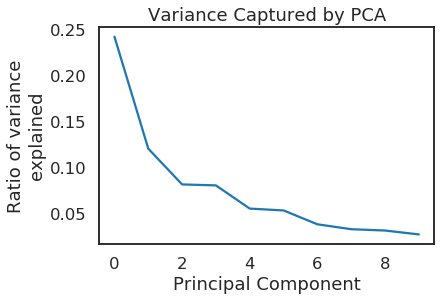

In [7]:
# Plot the variances captured by PCs over all trials
variances = np.array(lvm_pca.pca.explained_variance_ratio_)
variances_few = np.expand_dims(variances[:10], axis=0)
plt.figure()
df = pd.DataFrame(variances_few).melt()
sns.lineplot(x="variable", y="value", data=df)
plt.xlabel("Principal Component")
plt.ylabel("Ratio of variance\nexplained")
plt.title("Variance Captured by PCA")
plt.show()

In [8]:
delay_data.shape

(393, 29, 200)

In [9]:
np.sum(variances[:15])

0.8597295583894403

<Figure size 432x288 with 0 Axes>

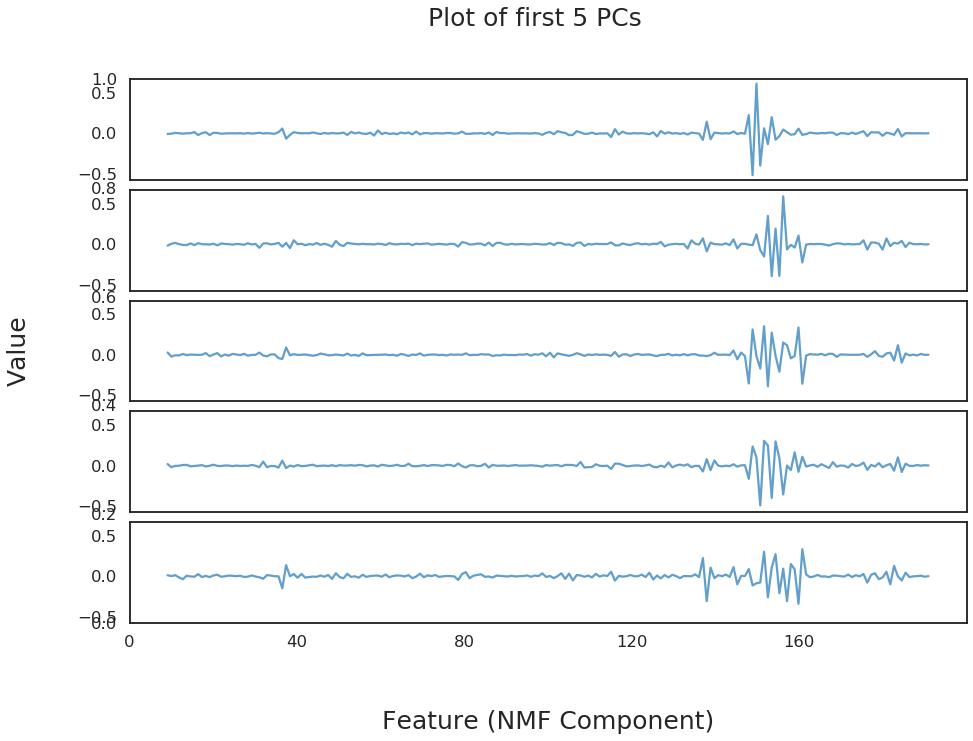

In [117]:
# Plot a few PCs
plt.figure()
num_pcs = 5
fig, axes = plt.subplots(
    nrows=num_pcs, ncols=1, figsize=(15,10),
    gridspec_kw={'height_ratios':[1/num_pcs]*num_pcs, 'hspace':0.1, 'wspace':0.1},
    sharex=True, sharey='col'
    )
for col in range(axes.size):
    ax = axes[col]
    ax.plot(latents[col,:].T, alpha=0.7)
    ax.tick_params(
        axis='both', which='both',
        bottom=False, top=False, left=False, labelbottom=False
        )
fig.add_subplot(111, frameon=False)
plt.xlabel('\n\nFeature (NMF Component)', fontsize=25)
plt.ylabel('Value\n\n', fontsize=25)
plt.suptitle("Plot of first 5 PCs", fontsize=25)
plt.xticks(ticks=np.arange(0,1,.2),labels=np.arange(0,latents.shape[1],40))
plt.show()

## Plot Session PCAs during the quiescent periods

In [11]:
all_neural_data.shape

(393, 189, 200)

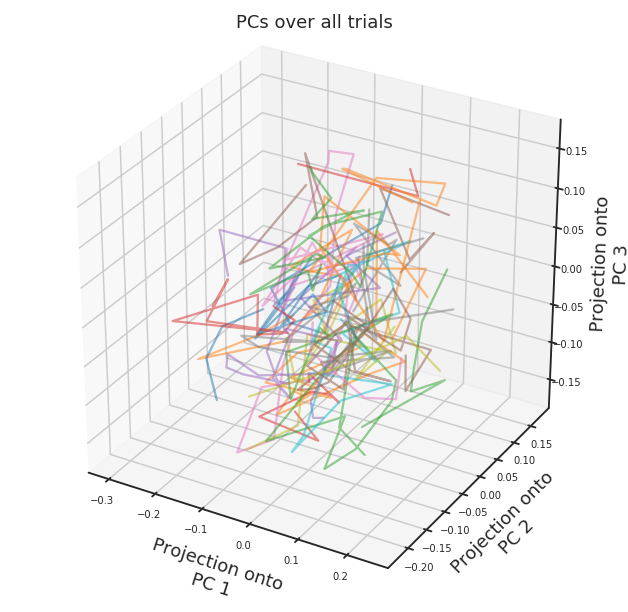

In [100]:
cm = plt.get_cmap('winter')
fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(111, projection="3d")
for trial in range(latents.shape[0]//4):
    start, end = quiescent_indices[trial,:]
    if end-start < 3:
        continue
    quiescent_activity = all_neural_data[trial,start:end,:]
    projections = lvm_pca.get_latent_projections(quiescent_activity)
    p1 = projections[:,0]
    p2 = projections[:,1]
    p3 = projections[:,2]
    ax.plot(p1, p2, p3, alpha=0.5)
ax.set_xlabel('\n\nProjection onto\nPC 1')
ax.set_ylabel('\n\nProjection onto\nPC 2')
ax.set_zlabel('\n\nProjection onto\nPC 3')
plt.tick_params(labelsize=10);
plt.title("PCs over all trials\n")
plt.show()

## Plot Session PCAs during the quiescent periods, separating by left/right choice

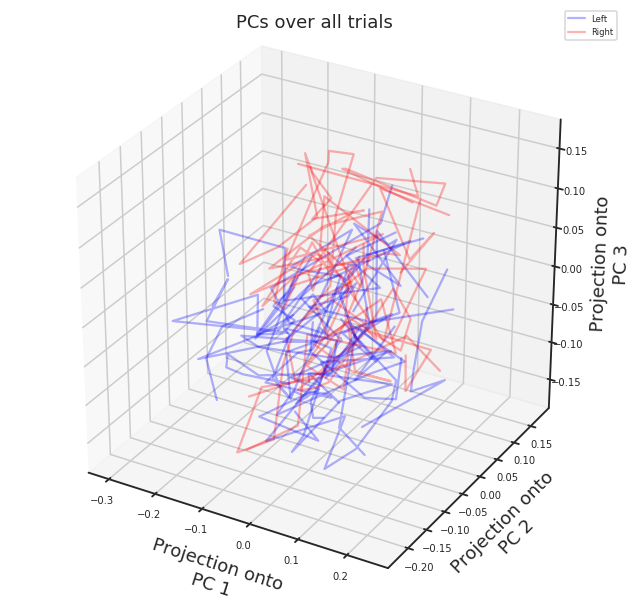

In [13]:
trial_choices = session.trialmarkers['ResponseSide']
cm = plt.get_cmap('winter')
fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(111, projection="3d")
for trial in range(latents.shape[0]//4):
    start, end = quiescent_indices[trial,:]
    if end-start < 3:
        continue
    quiescent_activity = all_neural_data[trial,start:end,:]
    projections = lvm_pca.get_latent_projections(quiescent_activity)
    p1 = projections[:,0]
    p2 = projections[:,1]
    p3 = projections[:,2]
    if trial_choices[trial] == 1: #Left Side
        ax.plot(p1, p2, p3, color='blue', alpha=0.3, label="Left")
    elif trial_choices[trial] == 2: #Right Side
        ax.plot(p1, p2, p3, color='red', alpha=0.3, label="Right")
ax.set_xlabel('\n\nProjection onto\nPC 1')
ax.set_ylabel('\n\nProjection onto\nPC 2')
ax.set_zlabel('\n\nProjection onto\nPC 3')
plt.tick_params(labelsize=10);
plt.title("PCs over all trials\n")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
font_prop = FontProperties()
font_prop.set_size('small')
plt.legend(by_label.values(), by_label.keys(), prop=font_prop)
plt.show()

# Plot PC trajectories for a few trials 
We will look at 4-5 trials, for 7 or so PC trajectories

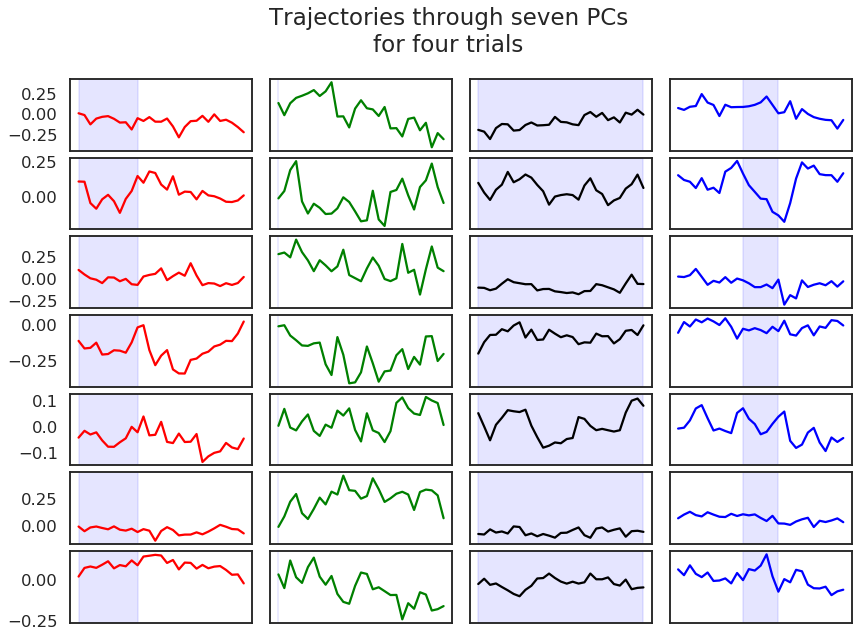

In [98]:
num_trials = 4
num_pcs = 7
fig, axes = plt.subplots(
    nrows=num_pcs, ncols=num_trials, figsize=(14,10),
    gridspec_kw={'height_ratios':[1/num_pcs]*num_pcs, 'hspace':0.1, 'wspace':0.1},
    sharex=False, sharey='row'
    )
for col in range(axes.shape[1]): # Iterate over trials
    trial = col
    start = delay_period_indices[trial,:][0]
    activity = all_neural_data[trial,start:start + min_delay_size,:]
    projections = lvm_pca.get_latent_projections(activity)
    nonmovement_start, nonmovement_end = quiescent_indices[trial,:]
    color = ['r','g','k','b'][col]
    for row in range(axes.shape[0]): # Iterate over PCs
        projection = projections[:,row]
        ax = axes[row, col]
        ax.plot(projection, color=color)
        ax.tick_params(
            axis='both', which='both',
            bottom=False, top=False, left=False, labelbottom=False
            )
        ax.axvspan(
            nonmovement_start - start, nonmovement_end - start,
            color='blue', alpha=0.1
        )

plt.suptitle("Trajectories through seven PCs\nfor four trials", fontsize=23)
plt.show()

# Decoding with LR
Use the first 15 PCs

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

In [47]:
def run_decoding(num_latents=10):
    # Extract training and test data
    X = []
    y = []
    trial_choices = session.trialmarkers['ResponseSide']
    for trial in range(trial_choices.size):
        choice = trial_choices[trial]
        if np.isnan(choice):
            continue
        start = delay_period_indices[trial,:][0]
        activity = all_neural_data[trial,start:start + min_delay_size,:]
        projection = lvm_pca.get_latent_projections(activity)
        X.append(projection[:,:num_latents].flatten())
        y.append(int(choice-1))
    X = np.array(X)
    y = np.array(y)
    
    # Training the model with cross validation
    log_reg = LogisticRegression()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    results = cross_validate(
        log_reg, X, y, scoring='accuracy',
        cv=5, n_jobs=-1, return_estimator=True
        )
    return results

In [76]:
vals = []
for num_latents in range(1,16):
    results = run_decoding(num_latents=num_latents)
    vals.append(results['test_score'])
vals = np.array(vals).T

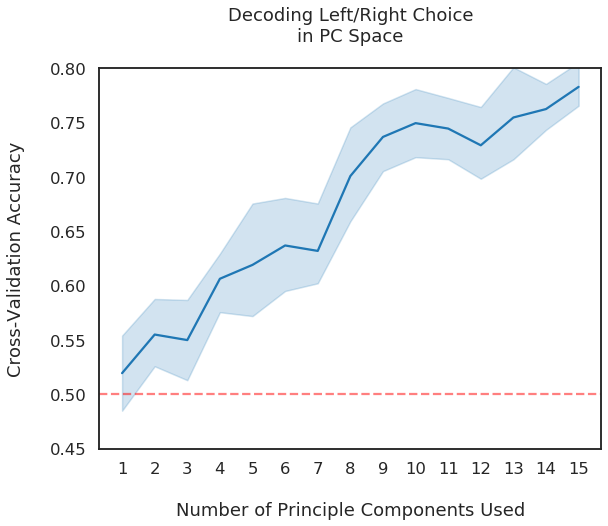

In [82]:
plt.figure(figsize=(9,7))
df = pd.DataFrame(vals).melt()
ax = sns.lineplot(x="variable", y="value", data=df)
plt.ylim((0.45,0.8))
ax.axhline(y=0.5, color='red', alpha=0.5, linestyle="--")
plt.xticks(ticks=np.arange(0,15),labels=np.arange(1,16))
plt.title("Decoding Left/Right Choice\nin PC Space\n")
plt.xlabel("\nNumber of Principle Components Used")
plt.ylabel("Cross-Validation Accuracy\n")
plt.show()

In [118]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib
import matplotlib.pyplot as plt

import ssm
from ssm.util import find_permutation

# Set the parameters of the HMM
T = 500     # number of time bins
K = 5       # number of discrete states
D = 2       # number of observed dimensions

# Make an HMM with the true parameters
true_hmm = ssm.HMM(K, D, observations="diagonal_gaussian")
z, y = true_hmm.sample(T)
z_test, y_test = true_hmm.sample(T)
true_ll = true_hmm.log_probability(y)

# Fit models
N_sgd_iters = 1000
N_em_iters = 100


Fitting ar HMM with sgd


Fitting ar HMM with em


Test log likelihood
True:  -792.9849518089275
ar (sgd): -824.1684927779067
ar (em): -845.1247889357885


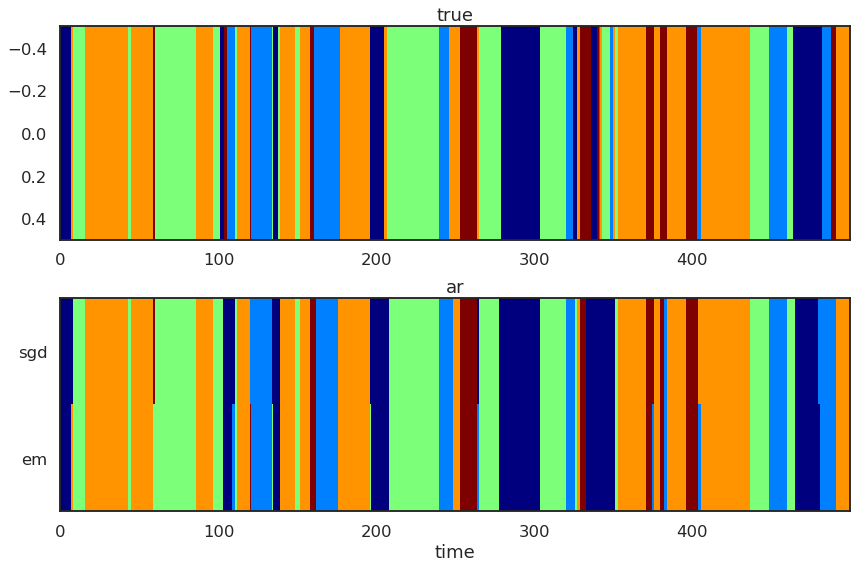

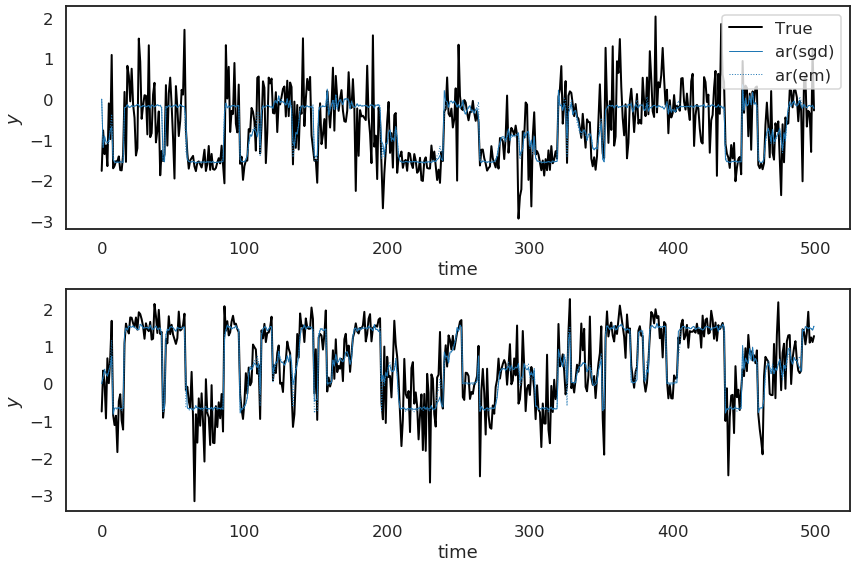

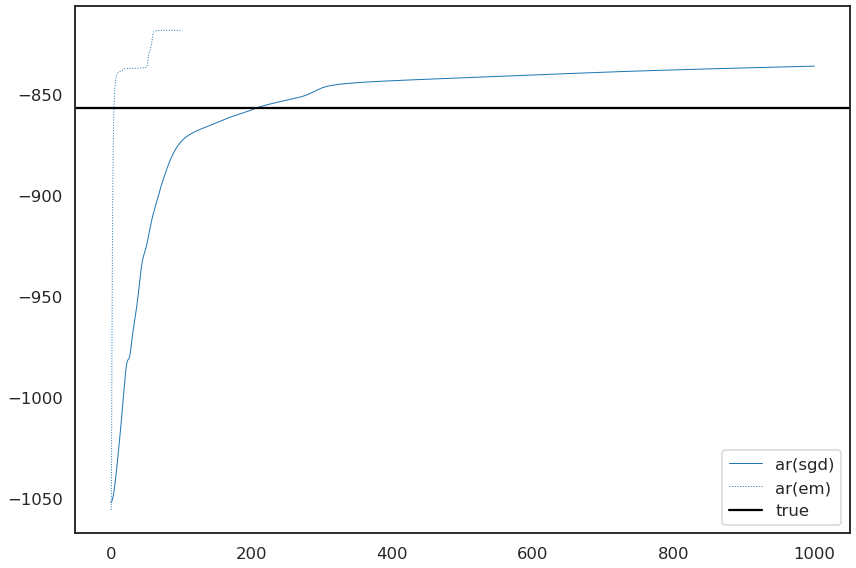

In [124]:
# A bunch of observation models that all include the
# diagonal Gaussian as a special case.
observations = [
    "ar"
]

# Fit with both SGD and EM
methods = ["sgd", "em"]

results = {}
for obs in observations:
    for method in methods:
        print("Fitting {} HMM with {}".format(obs, method))
        model = ssm.HMM(K, D, observations=obs)
        train_lls = model.fit(y, method=method)
        test_ll = model.log_likelihood(y_test)
        smoothed_y = model.smooth(y)

        # Permute to match the true states
        model.permute(find_permutation(z, model.most_likely_states(y)))
        smoothed_z = model.most_likely_states(y)
        results[(obs, method)] = (model, train_lls, test_ll, smoothed_z, smoothed_y)

# Plot the inferred states
fig, axs = plt.subplots(len(observations) + 1, 1, figsize=(12, 8))

# Plot the true states
plt.sca(axs[0])
plt.imshow(z[None, :], aspect="auto", cmap="jet")
plt.title("true")
plt.xticks()

# Plot the inferred states
for i, obs in enumerate(observations):
    zs = []
    for method, ls in zip(methods, ['-', ':']):
        _, _, _, smoothed_z, _ = results[(obs, method)]
        zs.append(smoothed_z)

    plt.sca(axs[i+1])
    plt.imshow(np.row_stack(zs), aspect="auto", cmap="jet")
    plt.yticks([0, 1], methods)
    if i != len(observations) - 1:
        plt.xticks()
    else:
        plt.xlabel("time")
    plt.title(obs)

plt.tight_layout()

# Plot smoothed observations
fig, axs = plt.subplots(D, 1, figsize=(12, 8))

# Plot the true data
for d in range(D):
    plt.sca(axs[d])
    plt.plot(y[:, d], '-k', lw=2, label="True")
    plt.xlabel("time")
    plt.ylabel("$y_{{}}$".format(d+1))

for obs in observations:
    line = None
    for method, ls in zip(methods, ['-', ':']):
        _, _, _, _, smoothed_y = results[(obs, method)]
        for d in range(D):
            plt.sca(axs[d])
            color = line.get_color() if line is not None else None
            line = plt.plot(smoothed_y[:, d], ls=ls, lw=1, color=color, label="{}({})".format(obs, method))[0]

# Make a legend
plt.sca(axs[0])
plt.legend(loc="upper right")
plt.tight_layout()

# Plot log likelihoods
plt.figure(figsize=(12, 8))
for obs in observations:
    line = None
    for method, ls in zip(methods, ['-', ':']):
        _, lls, _, _, _ = results[(obs, method)]
        color = line.get_color() if line is not None else None
        line = plt.plot(lls, ls=ls, lw=1, color=color, label="{}({})".format(obs, method))[0]

xlim = plt.xlim()
plt.plot(xlim, true_ll * np.ones(2), '-k', label="true")
plt.xlim(xlim)

plt.legend(loc="lower right")
plt.tight_layout()

# Print the test log likelihoods
print("Test log likelihood")
print("True: ", true_hmm.log_likelihood(y_test))
for obs in observations:
    for method in methods:
        _, _, test_ll, _, _ = results[(obs, method)]
        print("{} ({}): {}".format(obs, method, test_ll))

plt.show()

In [ ]:
# Plot the inferred states
fig, axs = plt.subplots(len(observations) + 1, 1, figsize=(12, 8))

# Plot the true states
plt.sca(axs[0])
plt.imshow(z[None, :], aspect="auto", cmap="jet")
plt.title("true")
plt.xticks()

# Plot the inferred states
for i, obs in enumerate(observations):
    zs = []
    for method, ls in zip(methods, ['-', ':']):
        _, _, _, smoothed_z, _ = results[(obs, method)]
        zs.append(smoothed_z)

    plt.sca(axs[i+1])
    import pdb; pdb.set_trace()
    plt.imshow(np.row_stack(zs), aspect="auto", cmap="jet")
    plt.yticks([0, 1], methods)
    if i != len(observations) - 1:
        plt.xticks()
    else:
        plt.xlabel("time")
    plt.title(obs)

plt.tight_layout()

> <ipython-input-126-c25d46ce8a7e>(19)<module>()
-> plt.imshow(np.row_stack(zs), aspect="auto", cmap="jet")
(Pdb) smoothed_z.shape
(500,)
(Pdb) np.row_stack(zs).shape
(2, 500)
(Pdb) x = np.row_stack(zs)
(Pdb) x[:,5]
array([0, 0])
(Pdb) x[:,:5]
array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])
